# Compressor de Imagens

Alunos: 
 - Daniel Souza de Campos - 2018054664
 - Letícia da Silva Macedo Alves - 2018054443

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import statistics
import struct

In [2]:
# image entropy
def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def mostraInformacoesCompressao(imgReal, imgComprimida):
    print(f"RMSE: {rmse(imgReal, imgComprimida)}")
    print(f"PSNR: {psnr(imgReal, imgComprimida)}")

In [67]:
# huffman
from heapq import heappush, heappop, heapify
from collections import defaultdict

def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

def calcProbsValues(listaValores):
    """
    Recebe uma lista de números
    Retorna um dicionário no qual as chaves correspondem aos números e os valores correspondem à probabilidade de o número 
    aparecer na lista. 
    """
    dictValues = {}
    for valor in listaValores:
        if valor in dictValues:
            dictValues[valor] += 1
        else:
            dictValues[valor] = 1
    
    qtdValues = len(listaValores)
    dictProbs = defaultdict(float)
    dictProbs = {chave: float("{0:.7f}".format(valor/qtdValues)) for chave, valor in dictValues.items()}
    return dictProbs

def applyHuffman(histValues):
    """
    Recebe um dicionário no qual as chaves correspondem aos tons e os valores correspondem à probabilidade de o tom 
    aparecer.
    Retorna um dicionário no qual as chaves são os tons e os valores são os códigos de Huffman correspondentes
    """
    huffValues = encode(histValues)
    huffDict = {subLista[0]: subLista[1] for subLista in huffValues}

    return huffDict

In [68]:
def retira3BitsMenosSignificativos(img):
    #retira 3 bits
    return img & 0xF8

def retira4BitsMenosSignificativos(img):
    #retira 4 bits
    return img & 0xF0

def retira5BitsMenosSignificativos(img):
    #retira 4 bits
    return img & 0xE0

In [69]:
def calculaComprimentosCorrida (img):
    """
    Recebe uma imagem em formato de matriz
    
    Retorna uma lista de duplas na qual o primeiro elementro representa o tom e o segundo elemento representa quantas
    vezes seguidas ele apareceu
    """
    comprimentosCorrida = []
    
    tomAtual = -1
    qtdRepeticoes = 0
    
    for x in range(img.shape[0]):
        for y in range (img.shape[1]):
            if (tomAtual < 0):
                tomAtual = img[x][y]
                qtdRepeticoes += 1
            else:
                if (img[x][y] == tomAtual):
                    qtdRepeticoes += 1
                else:
                    comprimentosCorrida.append((tomAtual, qtdRepeticoes))
                    tomAtual = img[x][y]
                    qtdRepeticoes = 1
                        
    comprimentosCorrida.append((tomAtual, qtdRepeticoes))
    return comprimentosCorrida

In [70]:
def escreveParesNoArquivo(listaDuplas, arquivo):
    """
    Escreve no arquivo os elementos das duplas da lista de duplas passada. Assume que tudo já está em binário
    """
    for par in listaDuplas:
            arquivo.write(par[0])
            arquivo.write(par[1])

def escreveIndicadorFimTabela(arquivo):
    """
    Escreve um indicador de fim de tabela no arquivo. O indicador é composto de 1 byte de 0 seguido de 4 bytes de 0.
    Identificador que a tabela de probabilidades acabou ao guardar um tom 0 com probabilidade igual a 0
    Como só guardamos tons que aparecem na imagem, nenhum tom real terá probabilidade igual a 0
    """
    arquivo.write(struct.pack('B',0))
    arquivo.write(struct.pack('f',0))
    
def getBigHuffmanString(comprimentoCorrida, huffTons, huffQtds):
    stringHuffmanTons = ""
    stringHuffmanQtds = ""
    tamStringTons = 0
    tamStringQtds = 0
#     countPares = 0
    for par in comprimentoCorrida:
        huffmanTom = huffTons[par[0]]
        stringHuffmanTons += huffmanTom
        tamStringTons += len(huffmanTom)
            
        huffmanQtd = huffQtds[par[1]]
        stringHuffmanQtds += huffmanQtd
        tamStringQtds += len(huffmanQtd)
#       countPares += 1
    
#     print("TOTAL PARES ESCRITOS: ", countPares)
#     print("TAMANHO STRING BITS TONS: ",tamStringTons)
#     print("TAMANHO STRING BITS QTDS: ",tamStringQtds)
    
    return stringHuffmanTons, stringHuffmanQtds, tamStringTons, tamStringQtds

def escreveONumeroTotalDeBytesDaProximaSecao(arquivo, qtdsBytesString):
    """
    Escreve o número de bytes dessa seção para que seja possível descomprimir.
    Igual ao número de bytes total mais 1. Grava um número de 64 bits = 8 bytes para representar.
    Dessa forma, o tamanho máximo da próxima seção é igual ao maior número que pode ser representado por 8 bytes
    """
    totalBytesASeremEscritos = qtdsBytesString + 2
#     print("TOTAL BYTES A SEREM ESCRITOS: ",totalBytesASeremEscritos)
    #Representação binária do número
    seqBits = struct.pack('Q',totalBytesASeremEscritos)
#     print(seqBits)
    arquivo.write(seqBits)

def escreveBigHuffmanStringArquivo(arquivo, huffString, tamHuffString):
    #No range vai até isso menos 1
    qtdsBytesString = tamHuffString//8
    numBitsSobrando = tamHuffString - (qtdsBytesString*8)
#     print("BIG STRING BITS A SER ESCRITO faltando os dois últimos bytes modificados: ", huffString)
    
    escreveONumeroTotalDeBytesDaProximaSecao(arquivo, qtdsBytesString)
        
    #De oito em oito, ir traduzindo o binário para o arquivo
    ultimaPosicaoidxInicio = tamHuffString+(-numBitsSobrando)+(-8)+1
    countBytesEscritos = 0
    for idxInicio in range(0, ultimaPosicaoidxInicio, 8):
        idxFinal = idxInicio+8
        bitsASeremGravados = huffString[idxInicio:idxFinal]
#         print("BITS A SEREM GRAVADOS: ",bitsASeremGravados)
        bitsComprimidos = struct.pack('B',int(bitsASeremGravados,2))
        arquivo.write(bitsComprimidos)
#         countBytesEscritos += 1
    
    #Escrevo mais um byte para os bits sobrando ou não
#     countBytesEscritos +=1
    idxInicio = tamHuffString - numBitsSobrando
    bitsSobrandoCompletadosComZero = huffString[idxInicio:].zfill(8)
#     print("BITS A SEREM GRAVADOS: ",bitsSobrandoCompletadosComZero)
    bitsSobrando = struct.pack('B',int(bitsSobrandoCompletadosComZero,2))
    arquivo.write(bitsSobrando)
    
    #indicador de quantos bits levar em consideração do último byte de dados
    ultimoByte = "{0:b}".format(numBitsSobrando)
    ultimoByte = ultimoByte.zfill(8)
#     print("BITS A SEREM GRAVADOS: ",ultimoByte)
    ultimoByte = struct.pack('B',int(ultimoByte,2))
    arquivo.write(ultimoByte)
#     countBytesEscritos += 1
#     print("NUM BYTES ESCRITOS: ", countBytesEscritos)

def escreveAlturaLarguraImagemArquivo(file, imgHeight, imgWidth):
    alturaBits = struct.pack('i',imgHeight)
    larguraBits = struct.pack('i',imgWidth)
    file.write(larguraBits)
    file.write(alturaBits)
    

def comprimeImagem(endereco):
    img = cv2.imread(endereco,0)
#     img = np.zeros((5,10), dtype=np.int16)
#     img[0,:] = 250
#     img[1,:3] = 150
#     img[1,3:] = 200
#     img[2,:3] = 150
#     img[2,3:] = 200
#     img[3,:] = 100
#     img[4,:]=100
    
    imgWidth = img.shape[1]
    imgHeight = img.shape[0]
    
    imgPsicovisual = retira5BitsMenosSignificativos(img)
    listaParesCompCorrida = calculaComprimentosCorrida(imgPsicovisual)
    
    #Calcula as probabilidades de cada tom e quantidade aparecerem
    histTons = calcProbsValues([par[0] for par in listaParesCompCorrida])
    histQtds = calcProbsValues([par[1] for par in listaParesCompCorrida])
    
    # Aplica Huffman nos tons e quantidades do comprimento de corrida
    huffTons = {}
    huffQtds = {}
    huffTons = applyHuffman(histTons)
    huffQtds = applyHuffman(histQtds)
#     print(huffTons)
#     print(huffQtds)
    
    #Gera o nome do arquivo comprimido "originalCompressed.bin"
    nomeArquivo = endereco.split(".")[0]
    nomeArquivo += "Compressed.bin"
    
    #Grava os binários da tabela de probabilidades dos tons no arquivo comprimido
    #Os tons cabem em um byte 'B' e a probabilidade é um float e os gravamos com 'f'
    #Isso deve refletir na leitura
    probsTonsGuardado = [(struct.pack('B',el[0]), struct.pack('f',el[1])) for el in histTons.items()]
    probsQtdsGuardado = [(struct.pack('B',el[0]), struct.pack('f',el[1])) for el in histQtds.items()]
 
    with open(nomeArquivo,"wb") as file:
        escreveAlturaLarguraImagemArquivo(file, imgHeight, imgWidth)
        escreveParesNoArquivo(probsTonsGuardado, file)
        escreveIndicadorFimTabela(file)

        escreveParesNoArquivo(probsQtdsGuardado, file)
        escreveIndicadorFimTabela(file)
        
        stringHuffmanTons, stringHuffmanQtds, tamStringTons, tamStringQtds = getBigHuffmanString(listaParesCompCorrida, 
                                                                                                 huffTons,
                                                                                                 huffQtds)
        escreveBigHuffmanStringArquivo(file, stringHuffmanTons, tamStringTons)
        
        escreveBigHuffmanStringArquivo(file, stringHuffmanQtds, tamStringQtds)
        
    return listaParesCompCorrida

In [71]:
def leAlturaLarguraImagemArquivo(file):
    alturaBits = file.read(4)
    alturaBits = struct.unpack('i',alturaBits)[0]
#     print("Altura lida: ",alturaBits)
    larguraBits = file.read(4)
    larguraBits = struct.unpack('i',larguraBits)[0]
#     print("Largura lida: ",larguraBits)
    return larguraBits, alturaBits

def leTabelaProbs(arquivo):
    tabelaProbs = {}
    tom = arquivo.read(1)
    while tom:
        prob = arquivo.read(4)
        #Se é a probabilidade do tom é 0, significa que a tabela acabou
        if(struct.unpack('f',prob)[0] == 0.0):
            break
        tabelaProbs[struct.unpack('B',tom)[0]] = struct.unpack('f',prob)[0]
        tom = arquivo.read(1)
    return tabelaProbs

def leSessaoBigStringBits(arquivo):
    bitsNumBytesSessao = arquivo.read(8)
#     print(bitsNumBytesSessao)
    numBytesSessao = struct.unpack('Q',bitsNumBytesSessao)[0]
#     print("NUM BYTES SESSAO: ", numBytesSessao)
    
    bigStringBits = ""
#     countBytesLidos = 0
    for numByte in range(numBytesSessao):
        byteLido = arquivo.read(1)
        #Número inteiro que representa o byte lido
        intByteLido = struct.unpack('B', byteLido)[0]
        
        #Se for o byte indicador de quantos bits levar em consideração do último byte
        if(numByte == numBytesSessao - 1):
#             print("Num bits sobrando: ", intByteLido)
            idxInicioUltimoByte = (8*(numBytesSessao-2))
            bigStringBits = bigStringBits[0:idxInicioUltimoByte] + bigStringBits[(idxInicioUltimoByte+(8-intByteLido)):]
        else:
            sequenciaBits = bin(intByteLido)[2:]
            sequenciaBits = sequenciaBits.zfill(8)
#             print("SEQUENCIA BITS A SER LIDO: ", sequenciaBits)
            bigStringBits += str(sequenciaBits)
#         countBytesLidos +=1
    
#     print("BIG STRING BITS LIDO: ", bigStringBits)
    
#     print("BYTES LIDOS: ",countBytesLidos)
    return bigStringBits
    

def transformaStringEmLista(stringBits, codHuffman):
    listaValores = []
    
    idxInicio = 0
    quantidadeBitsLidos = 1
    adicionouUltimo = False
    while(idxInicio + quantidadeBitsLidos < len(stringBits)):
        sequenciaBits = stringBits[idxInicio:idxInicio+quantidadeBitsLidos]
        if sequenciaBits in codHuffman:
            listaValores.append(codHuffman[sequenciaBits])
            idxInicio += quantidadeBitsLidos
            quantidadeBitsLidos = 1
            adicionouUltimo = True
        else:
            adicionouUltimo = False
            quantidadeBitsLidos += 1
    
    if not adicionouUltimo:
        sequenciaBits = stringBits[idxInicio:idxInicio+quantidadeBitsLidos+1]
        listaValores.append(codHuffman[sequenciaBits])
    
    return listaValores

def restauraImagem(listaTons, listaQtds, larguraImg, alturaImg):
    img = np.zeros(larguraImg*alturaImg, dtype=np.int16)
    
    idxInicial = 0
    for i in range(len(listaTons)):
        qtdTom = listaQtds[i]
        img[idxInicial: idxInicial+qtdTom] = int(listaTons[i])
        idxInicial += qtdTom
    
    img = np.reshape(img, (larguraImg, alturaImg))
    return img
    
    
def descomprimirImagem(endereco):
    #Lê a tabela de probabilidade dos tons.
    #Como o tom é gravado com 1 byte, o gravamos com 'B' e o lemos do mesmo jeito
    #Como a probabilidade é um float, ele é gravado com 'f' e o lemos do mesmo jeito
    probsTonsDescomprimido = {}
    probsQtdsDescomprimido = {}
    stringBitsTons = ""
    stringBitsQtds = ""
    larguraImg = 0
    alturaImg = 0
    with open(endereco,"rb") as file:
        larguraImg, alturaImg = leAlturaLarguraImagemArquivo(file)
        probsTonsDescomprimido = leTabelaProbs(file)
        probsQtdsDescomprimido = leTabelaProbs(file)
        stringBitsTons = leSessaoBigStringBits(file)
        stringBitsQtds = leSessaoBigStringBits(file)
        
    #Dicionários de códigos de Huffman cuja chave é o próprio código 
    huffmanTons = {par[1]: par[0] for par in applyHuffman(probsTonsDescomprimido).items()}
#     print(huffmanTons)
    huffmanQtds = {par[1]: par[0] for par in applyHuffman(probsQtdsDescomprimido).items()}
#     print(huffmanQtds)
#     print("Codigo Huffman Tons")
    listaTonsOrdemAparecem = transformaStringEmLista(stringBitsTons, huffmanTons)
#     print("Codigo Huffman Qtds")
    listaQtdsOrdemAparecem = transformaStringEmLista(stringBitsQtds, huffmanQtds)
    
#     print("Tamanho lista tons: ",len(listaTonsOrdemAparecem))
#     print("Tamanho lista qtds: ",len(listaQtdsOrdemAparecem))
    
    img = restauraImagem(listaTonsOrdemAparecem, listaQtdsOrdemAparecem, larguraImg, alturaImg)
    
    return img
    
    #consegue a lista de pares
    #aplica geraImagemComprimentosCorrida
    #grava essa imagem descomprimida
    
def geraImagemComprimentosCorrida(largura, altura, comprimentosCorrida):
    imagemVetorizada = np.zeros(largura*altura, dtype=np.int16)
    indexInicio = 0
    indexFim = 0
    
    for (x,y) in comprimentosCorrida:
        indexFim += y 
        imagemVetorizada[indexInicio:indexFim] = int(x)
        indexInicio = indexFim
    
    imagemReconstruida = np.reshape(imagemVetorizada, (altura, largura))
    
    return imagemReconstruida

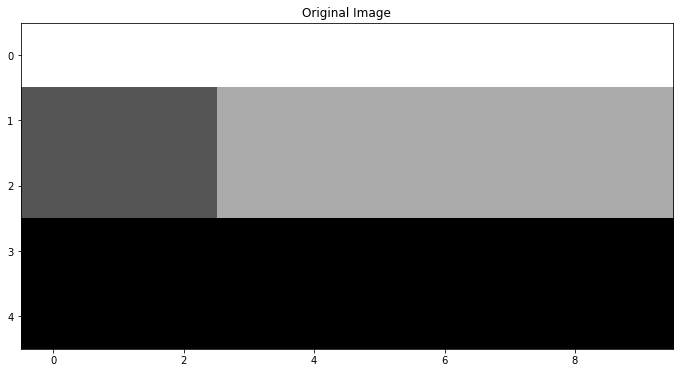

In [72]:
img = np.zeros((5,10), dtype=np.int16)
img[0,:] = 250
img[1,:3] = 150
img[1,3:] = 200
img[2,:3] = 150
img[2,3:] = 200
img[3,:] = 100
img[4,:]=100
plt.figure(figsize=(12,6))
plt.title('Original Image')
plt.imshow(img, cmap = 'gray')
plt.show()

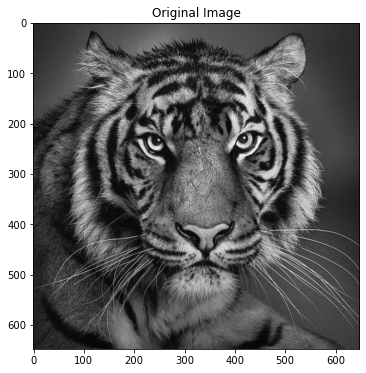

In [73]:
# original
tigre = cv2.imread('tigre.jpg',0)
plt.figure(figsize=(12,6))
plt.title('Original Image')
plt.imshow(tigre, cmap = 'gray')
plt.show()

In [74]:
print(f"Entropia :{calcEntropy(tigre)}")

Entropia :7.425243377685547


In [75]:
testeTigre = comprimeImagem('tigre.jpg')

In [76]:
tigreDescomprimido = descomprimirImagem("tigreCompressed.bin")

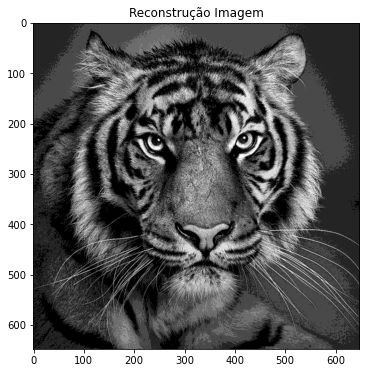

In [77]:
plt.figure(figsize=(12,6))
plt.title('Reconstrução Imagem')
plt.imshow(tigreDescomprimido, cmap = 'gray')
plt.show()

In [28]:
max(testeTigre, key=lambda item:item[1])[0]

32

In [29]:
min(testeTigre, key=lambda item:item[0])[0]

0

In [30]:
print(len(testeTigre))

138455


In [31]:
print(tigre.shape[0]*tigre.shape[1])

419904


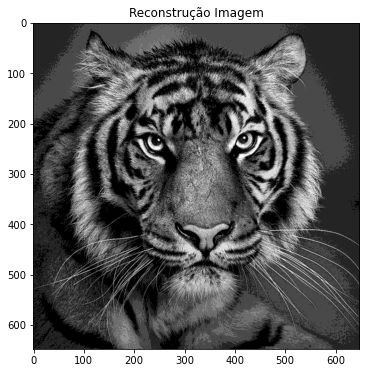

RMSE: 17.75599807743728
PSNR: 23.14390182209284


In [32]:
tigreReconstruido = geraImagemComprimentosCorrida(tigre.shape[0], tigre.shape[1], testeTigre)
plt.figure(figsize=(12,6))
plt.title('Reconstrução Imagem')
plt.imshow(tigreReconstruido, cmap = 'gray')
plt.show()
mostraInformacoesCompressao(tigre, tigreReconstruido)

In [33]:
np.min(tigreReconstruido)

0

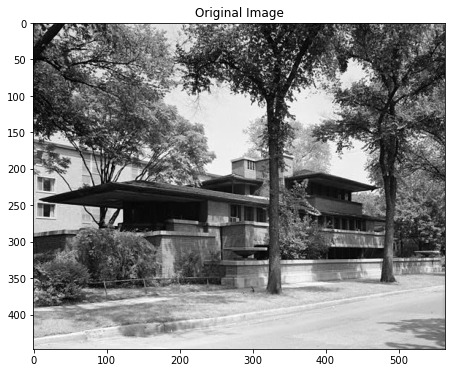

In [34]:
# original
casa = cv2.imread('casa.jpg',0)
plt.figure(figsize=(12,6))
plt.title('Original Image')
plt.imshow(casa, cmap = 'gray')
plt.show()

In [35]:
testeCasa = comprimeImagem('casa.jpg')

In [36]:
casaDescomprimido = descomprimirImagem("casaCompressed.bin")

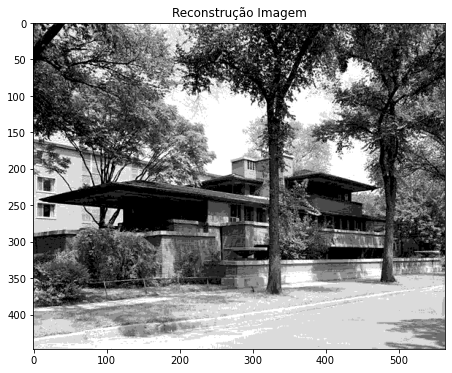

In [37]:
plt.figure(figsize=(12,6))
plt.title('Reconstrução Imagem')
plt.imshow(casaDescomprimido, cmap = 'gray')
plt.show()

In [38]:
print(casa.shape[0]*casa.shape[1])
print(len(testeCasa))

252108
101303


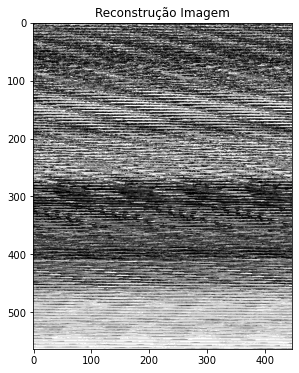

In [39]:
casaReconstruida = geraImagemComprimentosCorrida(casa.shape[0], casa.shape[1], testeCasa)
plt.figure(figsize=(12,6))
plt.title('Reconstrução Imagem')
plt.imshow(casaReconstruida, cmap = 'gray')
plt.show()

In [40]:
mostraInformacoesCompressao(casa, casaReconstruida)

ValueError: operands could not be broadcast together with shapes (447,564) (564,447) 

In [ ]:
casaReconstruida2 = comprimeImagem(casaReconstruida)

In [41]:
casaReconstruida22 = geraImagemComprimentosCorrida(casa.shape[0], casa.shape[1], casaReconstruida2)
plt.figure(figsize=(12,6))
plt.title('Reconstrução Imagem')
plt.imshow(casaReconstruida22, cmap = 'gray')
plt.show()

NameError: name 'casaReconstruida2' is not defined

In [ ]:
mostraInformacoesCompressao(casa, casaReconstruida22)